Imports

In [96]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv
from mmdet.datasets.pipelines import Compose
from mmcv.parallel import collate, scatter
import matplotlib.pyplot as plt
import cv2
import numpy as np
from mmdet.core.visualization import imshow_det_bboxes

Initialize Model

In [77]:
config_file = '../configs/mapillary/mapillary_frcnn_full_fpn_coco.py'
checkpoint_file = '../work_dirs/mapillary_frcnn_full_fpn_coco/epoch_12.pth'

In [78]:
model = init_detector(config_file, checkpoint_file, device='cuda:0')

load checkpoint from local path: ../work_dirs/mapillary_frcnn_full_fpn_coco/epoch_12.pth


In [ ]:
model.CLASSES = ['regulatory--stop--g1', 'regulatory--keep-left--g1', 'complementary--chevron-right--g5', 'information--parking--g1', 'warning--bicycles-crossing--g2', 'warning--curve-left--g2', 'regulatory--no-entry--g1', 'regulatory--go-straight--g1', 'regulatory--yield--g1', 'warning--trail-crossing--g2', 'complementary--keep-left--g1', 'regulatory--no-parking--g5', 'regulatory--no-parking--g1', 'information--parking--g3', 'complementary--distance--g3', 'regulatory--maximum-speed-limit-50--g1', 'warning--road-widens-right--g1', 'regulatory--no-overtaking--g1', 'warning--roadworks--g1', 'warning--other-danger--g1', 'warning--road-narrows-left--g1', 'warning--slippery-road-surface--g2', 'warning--roadworks--g2', 'warning--roundabout--g25', 'complementary--chevron-left--g4', 'warning--children--g2', 'regulatory--no-overtaking--g5', 'warning--uneven-roads-ahead--g1', 'regulatory--turn-right-ahead--g1', 'regulatory--road-closed-to-vehicles--g3', 'complementary--go-left--g1', 'regulatory--keep-right--g4', 'information--tram-bus-stop--g2', 'complementary--obstacle-delineator--g2', 'information--bus-stop--g1', 'warning--children--g1', 'regulatory--turn-left--g1', 'warning--road-bump--g1', 'regulatory--no-stopping--g15', 'regulatory--maximum-speed-limit-30--g1', 'warning--curve-right--g1', 'warning--junction-with-a-side-road-perpendicular-left--g1', 'warning--narrow-bridge--g1', 'regulatory--no-parking--g2', 'regulatory--one-way-right--g3', 'warning--railroad-crossing-without-barriers--g3', 'warning--railroad-crossing-with-barriers--g1', 'regulatory--maximum-speed-limit-120--g1', 'regulatory--no-u-turn--g1', 'regulatory--no-motorcycles--g1', 'complementary--chevron-left--g2', 'regulatory--weight-limit--g1', 'regulatory--width-limit--g1', 'warning--curve-right--g2', 'complementary--maximum-speed-limit-55--g1', 'regulatory--pedestrians-only--g1', 'regulatory--passing-lane-ahead--g1', 'warning--school-zone--g2', 'regulatory--no-right-turn--g1', 'regulatory--no-pedestrians--g2', 'warning--traffic-signals--g1', 'warning--curve-left--g1', 'complementary--chevron-right--g1', 'warning--traffic-merges-right--g1', 'regulatory--maximum-speed-limit-100--g1', 'regulatory--height-limit--g1', 'regulatory--no-straight-through--g2', 'regulatory--keep-right--g1', 'regulatory--priority-road--g4', 'regulatory--mopeds-and-bicycles-only--g1', 'warning--traffic-signals--g3', 'regulatory--turn-left--g2', 'complementary--go-right--g2', 'regulatory--no-heavy-goods-vehicles--g1', 'regulatory--bicycles-only--g1', 'regulatory--one-way-left--g3', 'regulatory--no-heavy-goods-vehicles--g2', 'information--hospital--g1', 'complementary--go-right--g1', 'regulatory--one-way-straight--g1', 'complementary--chevron-right--g3', 'warning--trucks-crossing--g1', 'information--living-street--g1', 'regulatory--one-way-right--g2', 'warning--domestic-animals--g1', 'information--pedestrians-crossing--g1', 'regulatory--one-way-right--g1', 'regulatory--maximum-speed-limit-40--g1', 'information--children--g1', 'warning--junction-with-a-side-road-acute-left--g1', 'warning--kangaloo-crossing--g1', 'warning--uneven-road--g6', 'warning--junction-with-a-side-road-perpendicular-right--g1', 'complementary--chevron-left--g5', 'complementary--chevron-left--g3', 'warning--turn-left--g1', 'complementary--maximum-speed-limit-25--g1', 'complementary--chevron-left--g1', 'warning--junction-with-a-side-road-acute-right--g1', 'complementary--chevron-right-unsure--g6', 'regulatory--no-left-turn--g2', 'warning--pedestrians-crossing--g5', 'information--motorway--g1', 'regulatory--maximum-speed-limit-40--g6', 'regulatory--no-u-turn--g2', 'regulatory--maximum-speed-limit-80--g1', 'warning--double-curve-first-left--g1', 'warning--slippery-road-surface--g1', 'complementary--distance--g1', 'regulatory--no-parking-or-no-stopping--g2', 'warning--pedestrians-crossing--g4', 'regulatory--turn-left-ahead--g1', 'complementary--turn-left--g2', 'warning--hairpin-curve-right--g1', 'information--gas-station--g3', 'regulatory--maximum-speed-limit-90--g1', 'regulatory--maximum-speed-limit-110--g1', 'regulatory--no-turns--g1', 'information--road-bump--g1', 'information--limited-access-road--g1', 'complementary--maximum-speed-limit-45--g1', 'regulatory--no-overtaking--g2', 'warning--uneven-road--g2', 'regulatory--keep-left--g2', 'regulatory--maximum-speed-limit-45--g1', 'regulatory--no-mopeds-or-bicycles--g1', 'regulatory--no-motor-vehicle-trailers--g1', 'warning--railroad-crossing-without-barriers--g1', 'complementary--tow-away-zone--g1', 'warning--horizontal-alignment-right--g1', 'regulatory--maximum-speed-limit-25--g1', 'regulatory--one-way-left--g1', 'warning--double-turn-first-right--g1', 'complementary--obstacle-delineator--g1', 'warning--winding-road-first-left--g1', 'regulatory--pass-on-either-side--g1', 'warning--pedestrians-crossing--g1', 'warning--road-narrows--g1', 'regulatory--no-motorcycles--g2', 'regulatory--no-vehicles-carrying-dangerous-goods--g1', 'regulatory--shared-path-pedestrians-and-bicycles--g1', 'regulatory--no-parking-or-no-stopping--g3', 'information--bike-route--g1', 'regulatory--maximum-speed-limit-45--g3', 'regulatory--no-turn-on-red--g1', 'regulatory--no-heavy-goods-vehicles--g4', 'warning--texts--g3', 'regulatory--pedestrians-only--g2', 'complementary--extent-of-prohibition-area-both-direction--g1', 'warning--junction-with-a-side-road-perpendicular-left--g4', 'information--parking--g6', 'regulatory--maximum-speed-limit-60--g1', 'regulatory--weight-limit-with-trucks--g1', 'warning--roundabout--g1', 'information--disabled-persons--g1', 'information--telephone--g1', 'warning--dual-lanes-right-turn-or-go-straight--g1', 'regulatory--no-motor-vehicles-except-motorcycles--g2', 'complementary--maximum-speed-limit-20--g1', 'warning--road-bump--g2', 'warning--railroad-crossing--g1', 'regulatory--end-of-maximum-speed-limit-70--g2', 'warning--winding-road-first-right--g1', 'regulatory--radar-enforced--g1', 'regulatory--maximum-speed-limit-25--g2', 'complementary--maximum-speed-limit-30--g1', 'regulatory--end-of-priority-road--g1', 'regulatory--maximum-speed-limit-70--g1', 'warning--steep-ascent--g7', 'warning--junction-with-a-side-road-perpendicular-left--g3', 'regulatory--maximum-speed-limit-100--g3', 'regulatory--maximum-speed-limit-20--g1', 'regulatory--roundabout--g1', 'complementary--pass-right--g1', 'regulatory--stop-here-on-red-or-flashing-light--g1', 'information--parking--g5', 'regulatory--no-left-turn--g1', 'warning--texts--g2', 'warning--winding-road-first-right--g3', 'regulatory--no-stopping--g5', 'information--safety-area--g2', 'warning--stop-ahead--g9', 'regulatory--pass-on-either-side--g2', 'regulatory--no-pedestrians--g3', 'regulatory--go-straight-or-turn-right--g1', 'warning--traffic-merges-left--g1', 'warning--traffic-merges-right--g2', 'warning--divided-highway-ends--g2', 'warning--two-way-traffic--g2', 'warning--roadworks--g4', 'warning--emergency-vehicles--g1', 'warning--wild-animals--g1', 'regulatory--no-overtaking-by-heavy-goods-vehicles--g1', 'complementary--distance--g2', 'regulatory--go-straight-or-turn-left--g3', 'warning--junction-with-a-side-road-perpendicular-right--g3', 'warning--railroad-crossing-without-barriers--g4', 'information--end-of-limited-access-road--g1', 'warning--crossroads--g3', 'regulatory--bicycles-only--g3', 'warning--turn-right--g1', 'warning--divided-highway-ends--g1', 'regulatory--turn-right--g2', 'warning--traffic-signals--g2', 'warning--railroad-intersection--g3', 'warning--double-curve-first-right--g2', 'warning--pass-left-or-right--g2', 'regulatory--turn-right--g3', 'regulatory--buses-only--g1', 'complementary--one-direction-left--g1', 'warning--height-restriction--g2', 'regulatory--no-right-turn--g2', 'warning--double-curve-first-right--g1', 'regulatory--go-straight-or-turn-left--g1', 'warning--traffic-signals--g4', 'warning--road-narrows--g2', 'warning--road-narrows-left--g2', 'warning--texts--g1', 'warning--crossroads--g1', 'regulatory--no-stopping--g2', 'regulatory--maximum-speed-limit-30--g3', 'regulatory--give-way-to-oncoming-traffic--g1', 'warning--playground--g1', 'regulatory--road-closed--g2', 'warning--road-narrows-right--g2', 'complementary--maximum-speed-limit-15--g1', 'warning--equestrians-crossing--g2', 'regulatory--no-pedestrians--g1', 'regulatory--one-way-left--g2', 'warning--roadworks--g6', 'information--gas-station--g1', 'information--pedestrians-crossing--g2', 'warning--wild-animals--g4', 'warning--pedestrians-crossing--g10', 'warning--flaggers-in-road--g1', 'warning--railroad-crossing--g3', 'regulatory--turn-left--g3', 'information--camp--g1', 'regulatory--maximum-speed-limit-55--g2', 'regulatory--no-straight-through--g1', 'information--dead-end--g1', 'regulatory--maximum-speed-limit-35--g2', 'regulatory--reversible-lanes--g2', 'warning--railroad-crossing--g4', 'information--food--g2', 'regulatory--no-heavy-goods-vehicles--g5', 'regulatory--u-turn--g1', 'regulatory--no-u-turn--g3', 'regulatory--lane-control--g1', 'regulatory--turn-right--g1', 'regulatory--go-straight-or-turn-left--g2', 'warning--double-curve-first-left--g2', 'warning--other-danger--g3', 'regulatory--keep-right--g2', 'complementary--one-direction-right--g1', 'information--emergency-facility--g2', 'regulatory--turning-vehicles-yield-to-pedestrians--g1', 'regulatory--no-buses--g3', 'regulatory--priority-over-oncoming-vehicles--g1', 'regulatory--dual-path-bicycles-and-pedestrians--g1', 'complementary--turn-right--g2', 'complementary--keep-right--g1', 'information--telephone--g2', 'complementary--chevron-right--g4', 'regulatory--maximum-speed-limit-5--g1', 'regulatory--no-heavy-goods-vehicles-or-buses--g1', 'complementary--trucks--g1', 'regulatory--keep-right--g6', 'regulatory--maximum-speed-limit-40--g3', 'information--end-of-built-up-area--g1', 'information--interstate-route--g1', 'regulatory--no-stopping--g8', 'regulatory--no-bicycles--g3', 'warning--pedestrians-crossing--g9', 'regulatory--end-of-prohibition--g1', 'warning--two-way-traffic--g1', 'regulatory--stop-here-on-red-or-flashing-light--g2', 'regulatory--turn-right-ahead--g2', 'warning--wombat-crossing--g1', 'complementary--maximum-speed-limit-70--g1', 'warning--falling-rocks-or-debris-right--g1', 'warning--domestic-animals--g3', 'warning--double-reverse-curve-right--g1', 'warning--falling-rocks-or-debris-right--g4', 'regulatory--dual-lanes-turn-right-or-straight--g1', 'information--trailer-camping--g1', 'information--end-of-living-street--g1', 'regulatory--no-bicycles--g2', 'regulatory--bicycles-only--g2', 'regulatory--no-parking-or-no-stopping--g1', 'warning--restricted-zone--g1', 'information--airport--g2', 'regulatory--maximum-speed-limit-led-60--g1', 'regulatory--no-motor-vehicles--g4', 'information--highway-exit--g1', 'information--end-of-motorway--g1', 'regulatory--end-of-no-parking--g1', 'regulatory--left-turn-yield-on-green--g1', 'complementary--accident-area--g3', 'regulatory--go-straight-or-turn-right--g3', 'warning--added-lane-right--g1', 'regulatory--road-closed-to-vehicles--g1', 'regulatory--no-turn-on-red--g2', 'information--parking--g2', 'warning--t-roads--g1', 'regulatory--dual-lanes-go-straight-on-right--g1', 'complementary--maximum-speed-limit-40--g1', 'regulatory--text-four-lines--g1', 'warning--hairpin-curve-left--g3', 'warning--winding-road-first-left--g2', 'warning--falling-rocks-or-debris-right--g2', 'warning--horizontal-alignment-left--g1', 'regulatory--maximum-speed-limit-65--g2', 'regulatory--triple-lanes-turn-left-center-lane--g1', 'warning--crossroads-with-priority-to-the-right--g1', 'complementary--except-bicycles--g1', 'complementary--both-directions--g1', 'regulatory--no-turn-on-red--g3', 'regulatory--no-right-turn--g3', 'warning--accidental-area-unsure--g2', 'warning--bicycles-crossing--g1', 'warning--roadworks--g3', 'warning--t-roads--g2', 'complementary--priority-route-at-intersection--g1', 'regulatory--parking-restrictions--g2', 'regulatory--no-motor-vehicles-except-motorcycles--g1', 'regulatory--maximum-speed-limit-10--g1', 'regulatory--end-of-bicycles-only--g1', 'information--central-lane--g1', 'regulatory--dual-path-pedestrians-and-bicycles--g1', 'regulatory--do-not-block-intersection--g1', 'regulatory--wrong-way--g1', 'regulatory--maximum-speed-limit-15--g1', 'information--stairs--g1', 'regulatory--detour-left--g1', 'complementary--trucks-turn-right--g1', 'warning--shared-lane-motorcycles-bicycles--g1', 'warning--pedestrian-stumble-train--g1', 'warning--pass-left-or-right--g1', 'regulatory--road-closed--g1', 'complementary--maximum-speed-limit-35--g1', 'regulatory--maximum-speed-limit-led-80--g1', 'warning--dip--g2', 'regulatory--end-of-maximum-speed-limit-30--g2', 'complementary--maximum-speed-limit-75--g1', 'regulatory--go-straight--g3', 'regulatory--no-stopping--g4', 'warning--offset-roads--g3', 'warning--bus-stop-ahead--g3', 'regulatory--no-bicycles--g1', 'regulatory--shared-path-bicycles-and-pedestrians--g1', 'complementary--buses--g1', 'information--lodging--g1', 'information--end-of-pedestrians-only--g2', 'warning--road-narrows-right--g1', 'information--airport--g1', 'regulatory--no-motor-vehicles--g1', 'regulatory--no-overtaking--g4', 'regulatory--maximum-speed-limit-50--g6', 'regulatory--end-of-speed-limit-zone--g1', 'warning--y-roads--g1', 'warning--narrow-bridge--g3', 'complementary--maximum-speed-limit-50--g1', 'regulatory--minimum-safe-distance--g1', 'regulatory--stop-signals--g1', 'warning--pedestrians-crossing--g11', 'warning--pedestrians-crossing--g12', 'warning--railroad-crossing-with-barriers--g2', 'warning--turn-right--g2', 'warning--trams-crossing--g1', 'warning--traffic-merges-left--g2', 'regulatory--no-pedestrians-or-bicycles--g1', 'warning--slippery-motorcycles--g1', 'regulatory--stop--g2', 'regulatory--do-not-stop-on-tracks--g1', 'regulatory--truck-speed-limit-60--g1', 'warning--playground--g3', 'warning--road-widens--g1', 'regulatory--dual-lanes-turn-left-no-u-turn--g1', 'information--parking--g45', 'warning--horizontal-alignment-right--g3', 'regulatory--end-of-buses-only--g1', 'warning--hairpin-curve-left--g1', 'regulatory--dual-lanes-turn-left-or-straight--g1', 'regulatory--stop--g10', 'regulatory--maximum-speed-limit-led-100--g1', 'warning--railroad-crossing-with-barriers--g4', 'regulatory--no-hawkers--g1', 'information--minimum-speed-40--g1', 'regulatory--no-left-turn--g3', 'warning--loop-270-degree--g1', 'warning--bicycles-crossing--g3', 'regulatory--dual-lanes-go-straight-on-left--g1', 'regulatory--roundabout--g2', 'information--no-parking--g3', 'information--highway-interstate-route--g2', 'warning--railroad-intersection--g4', 'regulatory--end-of-maximum-speed-limit-70--g1', 'warning--hairpin-curve-right--g4', 'information--dead-end-except-bicycles--g1']

Input Configuration

In [182]:
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=False)
data_pipeline = [
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1333, 800),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            # dict(type='RandomFlip'),
            dict(type='Normalize', **img_norm_cfg),
            dict(type='Pad', size_divisor=32),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img'], meta_keys=('ori_shape','img_shape', 'pad_shape', 'scale_factor', 'img_norm_cfg')),
        ])
]
data_pipeline = Compose(data_pipeline)

Load Image (Replace with ROS Image)

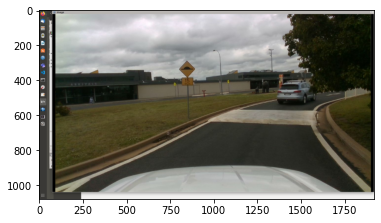

In [183]:
img = '../data/mapillary_sample/test/Screenshot from 2021-12-27 16-03-00.png'
image = cv2.imread(img)[:,:,::-1]
plt.imshow(image)

Image Preprocessing 

In [184]:
data = dict(img=image, ori_shape=image.shape) # RGB Format
data = data_pipeline(data)

In [185]:
data = collate([data], samples_per_gpu=1)
data = scatter(data, ['cuda:0'])[0]

Inference

In [186]:
results = model(return_loss=False, rescale=True, **data)

In [187]:
bboxes = np.vstack(results[0])
#bboxes format [x1,y1,x2,y2,score]
bboxes

array([[8.0217145e+02, 2.8691122e+02, 8.9340485e+02, 3.5996759e+02,
        6.5024354e-02],
       [8.2101367e+02, 3.8399249e+02, 8.8221631e+02, 4.2965500e+02,
        7.6979101e-02],
       [8.0210052e+02, 2.8805331e+02, 8.9175043e+02, 3.8531903e+02,
        9.9563158e-01],
       [8.1754993e+02, 3.8422684e+02, 8.8156860e+02, 4.2977213e+02,
        7.0214260e-01],
       [8.2246344e+02, 3.8332462e+02, 8.8279944e+02, 4.3009235e+02,
        5.5885732e-02],
       [8.2601434e+02, 3.8589441e+02, 8.7971063e+02, 4.2891272e+02,
        6.8040080e-02]], dtype=float32)

In [188]:
labels = [
            np.full(bbox.shape[0], i, dtype=np.int32)
            for i, bbox in enumerate(results[0])
        ]
labels = np.concatenate(labels)
labels

array([ 37,  54, 159, 225, 340, 344], dtype=int32)

In [189]:
viz_image = imshow_det_bboxes(
            image,
            bboxes,
            labels,
            class_names=model.CLASSES,
            score_thr=0.3,
            bbox_color=(72, 101, 241),
            text_color=(72, 101, 241),
            thickness=2,
            font_size=13,
            win_name='',
            show=False,
            wait_time=0,
            out_file=None)

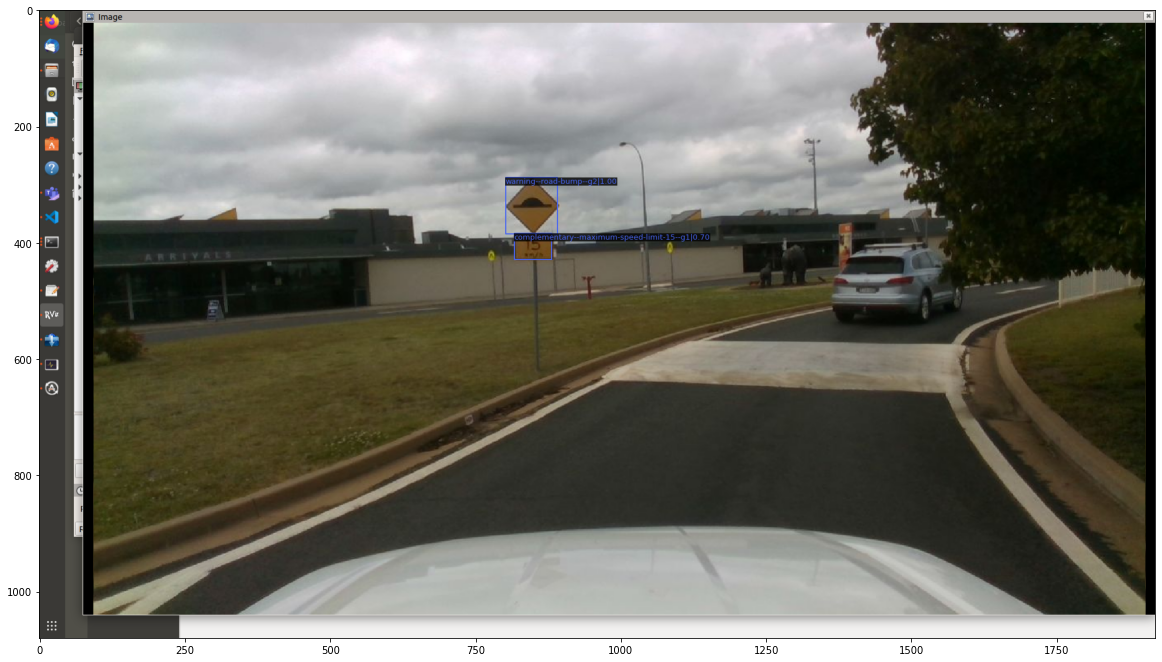

In [190]:
plt.figure(figsize=(20,20))
plt.imshow(viz_image)